# WIP

Based on https://github.com/aayushmnit/Deep_learning_explorations/tree/master/8_Image_similarity_search


In [1]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
#from lshash import LSHash
from PIL import Image
from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

In [19]:
# wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
dataset_path = '/home/recocat/notebooks/miguel/data/caltech101'
path = Path(dataset_path)

In [3]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

In [4]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 102
['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'se

In [5]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 7316
Test dataset size: 1828


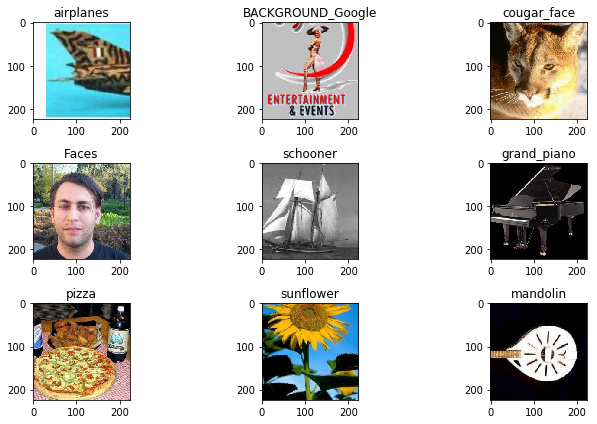

In [6]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False) 

In [7]:
## Creating the model
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


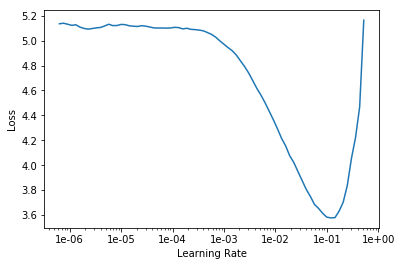

In [8]:
## Finding Ideal learning late
learn.lr_find()
learn.recorder.plot()

In [9]:
## Fitting 5 epochs
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.220074,0.516506,0.844639,00:17
1,0.928803,0.779915,0.788840,00:17
2,0.593597,0.481734,0.865974,00:17
3,0.326255,0.265215,0.921772,00:17
4,0.153840,0.233216,0.930525,00:17


In [11]:
## Saving stage 1
learn.save('stg1-rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


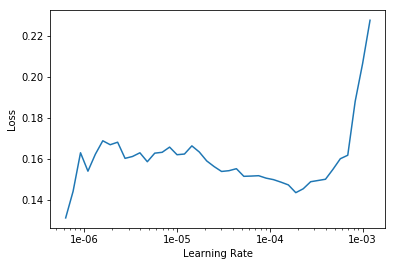

In [12]:
## Unfreeing layer and finding ideal learning rate
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
## Fitting 5 epochs
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.161996,0.313154,0.910832,00:22
1,0.264366,0.343463,0.906455,00:23
2,0.152005,0.256510,0.927790,00:22
3,0.067008,0.211445,0.939278,00:22
4,0.037430,0.204186,0.940919,00:23


In [14]:
## Saving model weights
learn.save('stg2-rn34')

In [15]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

In [16]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [18]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))
len(feature_dicture_dict)

9144

In [24]:
im1 = Path(dataset_path, "yin_yang", "image_0031.jpg")
feat1 = feature_dict[str(im1)]
print(feat1.shape)
im2 = Path(dataset_path, "yin_yang", "image_0060.jpg")
feat2 = feature_dict[str(im2)]
print(feat2.shape)
im3 = Path(dataset_path, "elephant", "image_0060.jpg")
feat3 = feature_dict[str(im3)]
print(feat3.shape)

(512,)
(512,)
(512,)


In [27]:
#https://github.com/Azure/ImageSimilarityUsingCntk
def compute_vector_distance(vec1, vec2, method, boL2Normalize=False, weights=[], bias=[], learner=[]):
    # Pre-processing
    if boL2Normalize:
        vec1 = vec1 / np.linalg.norm(vec1, 2)
        vec2 = vec2 / np.linalg.norm(vec2, 2)
    #assert (len(vec1) == len(vec2))

    # Distance computation
    vecDiff = vec1 - vec2
    method = method.lower()
    if method == 'l1':
        dist = sum(abs(vecDiff))
    elif method == 'l2':
        dist = np.linalg.norm(vecDiff, 2)
    elif method == 'normalizedl2':
        a = vec1 / np.linalg.norm(vec1, 2)
        b = vec2 / np.linalg.norm(vec2, 2)
        dist = np.linalg.norm(a - b, 2)
    elif method == "cosine":
        dist = scipy.spatial.distance.cosine(vec1, vec2)
    elif method == "correlation":
        dist = scipy.spatial.distance.correlation(vec1, vec2)
    elif method == "chisquared":
        dist = chiSquared(vec1, vec2)
    elif method == "normalizedchisquared":
        a = vec1 / sum(vec1)
        b = vec2 / sum(vec2)
        dist = chiSquared(a, b)
    elif method == "hamming":
        dist = scipy.spatial.distance.hamming(vec1 > 0, vec2 > 0)
    elif method == "mahalanobis":
        #assumes covariance matric is provided, e..g. using: sampleCovMat = np.cov(np.transpose(np.array(feats)))
        dist = scipy.spatial.distance.mahalanobis(vec1, vec2, sampleCovMat)
    elif method == 'weightedl1':
        feat = np.float32(abs(vecDiff))
        dist = np.dot(weights, feat) + bias
        dist = -float(dist)
        # assert(abs(dist - learnerL1.decision_function([feat])) < 0.000001)
    elif method == 'weightedl2':
        feat = (vecDiff) ** 2
        dist = np.dot(weights, feat) + bias
        dist = -float(dist)
    elif method == 'weightedl2prob':
        feat = (vecDiff) ** 2
        dist = learner.predict_proba([feat])[0][1]
        dist = float(dist)

    # elif method == 'learnerscore':
    #     feat = (vecDiff) ** 2
    #     dist = learner.base_estimator.decision_function([feat])[0]
    #     dist = -float(dist)
    else:
        raise Exception("Distance method unknown: " + method)
    #assert (not np.isnan(dist))
    return dist

In [28]:
print(compute_vector_distance(feat1, feat2, "l2"))
print(compute_vector_distance(feat1, feat3, "l2"))


63.272743
121.54097
